# Introduction

Concatenate the aerial and lidar patches and train segmentation models.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from fastai.vision.all import *
from fastai_metrics import * 
from fastai.data.all import *
import PIL

In [4]:
from datetime import date

In [5]:
from constants import DATADIR, MAPAI_MASKS, MAPAI_TRAIN, MAPAI_PATCHES

In [6]:
#torch.cuda.set_device(1)

# Load data

In [7]:
df = pd.read_csv(f'../csv/mapai_orig_and_fixed_patches_2022-11-26.csv')

In [8]:
df.head()

,image,lidar,mask,is_val,mask_percentage,is_building,location
0,/home/alex/data/mapai/data/train/images/6179_495_44.tif,/home/alex/data/mapai/data/train/lidar/6179_495_44.tif,/home/alex/data/mapai/data/train/masks/6179_495_44.tif,False,0.155224,True,6179_495
1,/home/alex/data/mapai/data/train/images/6051_690_84.tif,/home/alex/data/mapai/data/train/lidar/6051_690_84.tif,/home/alex/data/mapai/data/train/masks/6051_690_84.tif,False,0.000000,False,6051_690
2,/home/alex/data/mapai/data/train/images/6121_865_53.tif,/home/alex/data/mapai/data/train/lidar/6121_865_53.tif,/home/alex/data/mapai/data/train/masks/6121_865_53.tif,False,0.017824,True,6121_865
3,/home/alex/data/mapai/data/train/images/6173_630_27.tif,/home/alex/data/mapai/data/train/lidar/6173_630_27.tif,/home/alex/data/mapai/data/train/masks/6173_630_27.tif,False,0.000000,False,6173_630
4,/home/alex/data/mapai/data/train/images/6147_481_4.tif,/home/alex/data/mapai/data/train/lidar/6147_481_4.tif,/home/alex/data/mapai/data/train/masks/6147_481_4.tif,False,0.182664,True,6147_481


In [9]:
len(df)

43500

In [10]:
df['image_lidar'] = df['image'] + ';' + df['lidar']

In [11]:
df.head()

,image,lidar,mask,is_val,mask_percentage,is_building,location,image_lidar
0,/home/alex/data/mapai/data/train/images/6179_495_44.tif,/home/alex/data/mapai/data/train/lidar/6179_495_44.tif,/home/alex/data/mapai/data/train/masks/6179_495_44.tif,False,0.155224,True,6179_495,/home/alex/data/mapai/data/train/images/6179_495_44.tif;/home/alex/data/mapai/data/train/lidar/6179_495_44.tif
1,/home/alex/data/mapai/data/train/images/6051_690_84.tif,/home/alex/data/mapai/data/train/lidar/6051_690_84.tif,/home/alex/data/mapai/data/train/masks/6051_690_84.tif,False,0.000000,False,6051_690,/home/alex/data/mapai/data/train/images/6051_690_84.tif;/home/alex/data/mapai/data/train/lidar/6051_690_84.tif
2,/home/alex/data/mapai/data/train/images/6121_865_53.tif,/home/alex/data/mapai/data/train/lidar/6121_865_53.tif,/home/alex/data/mapai/data/train/masks/6121_865_53.tif,False,0.017824,True,6121_865,/home/alex/data/mapai/data/train/images/6121_865_53.tif;/home/alex/data/mapai/data/train/lidar/6121_865_53.tif
3,/home/alex/data/mapai/data/train/images/6173_630_27.tif,/home/alex/data/mapai/data/train/lidar/6173_630_27.tif,/home/alex/data/mapai/data/train/masks/6173_630_27.tif,False,0.000000,False,6173_630,/home/alex/data/mapai/data/train/images/6173_630_27.tif;/home/alex/data/mapai/data/train/lidar/6173_630_27.tif
4,/home/alex/data/mapai/data/train/images/6147_481_4.tif,/home/alex/data/mapai/data/train/lidar/6147_481_4.tif,/home/alex/data/mapai/data/train/masks/6147_481_4.tif,False,0.182664,True,6147_481,/home/alex/data/mapai/data/train/images/6147_481_4.tif;/home/alex/data/mapai/data/train/lidar/6147_481_4.tif


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43500 entries, 0 to 43499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            43500 non-null  object 
 1   lidar            43500 non-null  object 
 2   mask             43500 non-null  object 
 3   is_val           43500 non-null  bool   
 4   mask_percentage  8500 non-null   float64
 5   is_building      8500 non-null   object 
 6   location         8500 non-null   object 
 7   image_lidar      43500 non-null  object 
dtypes: bool(1), float64(1), object(6)
memory usage: 2.4+ MB


# Check instances

In [13]:
from plotting import plot_image_lidar_and_masks_from_df

array([<AxesSubplot: title={'center': '6179_495_44, (500, 500)'}>,
       <AxesSubplot: >], dtype=object)

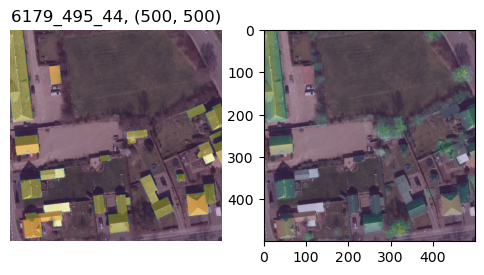

In [14]:
plot_image_lidar_and_masks_from_df(0, df)

# Create dataloaders

In [15]:
from training import BinaryConverter

In [16]:
codes = [0,1]

In [17]:
sz = (500,500)
half = tuple(int(x/2) for x in sz)

In [18]:
from training import get_multiband_dataloaders, get_multiband_item_tfms, get_cbs

In [19]:
bs = 24

In [20]:
dls = get_multiband_dataloaders(df, x_name='image_lidar', y_name='mask',
                      codes=codes,
                      splitter=ColSplitter('is_val'), bs=bs,
                      item_tfms=get_multiband_item_tfms(size=(half)),
                      batch_tfms=Normalize())

# Set up model

In [22]:
from loss_functions import multispectral_focal_tanimoto_loss, multispectral_ce_focaltversky

In [23]:
loss_func = multispectral_focal_tanimoto_loss

In [24]:
#opt = ranger

In [25]:
metrics = [Dice, iou]
models = [resnet34, resnet50, xresnet34, xresnet50]
model_idx = 0

In [26]:
model_name = str(models[model_idx]).split(' ')[1]
task = 'aerial-lidar'
model_name

'resnet34'

In [ ]:
learn = unet_learner(dls, models[model_idx], n_in=4, n_out=2, 
                     loss_func=loss_func,
                     pretrained=False, 
                     metrics=metrics,self_attention=False)

# Train model using progressive resizing

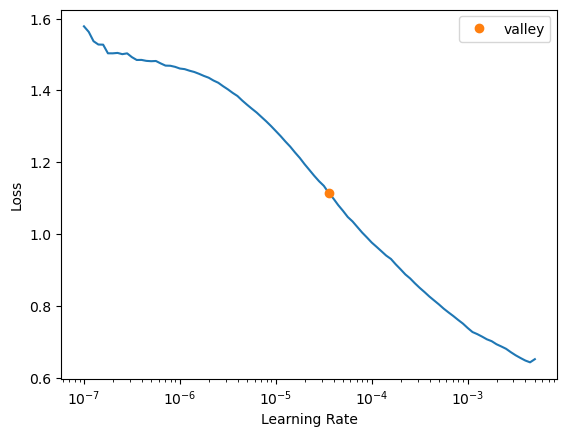

In [31]:
lr = learn.lr_find(end_lr=1e-2)

In [32]:
lr = lr.valley#*5

In [33]:
lr

3.548133827280253e-05

In [32]:
hole_size = (100,100)

In [33]:
save_fn = f'MapAI-stage_1-250_{model_name}_{task}-{date.today()}-cutmix-progressiveresize-focaltanimoto' 

epoch,train_loss,valid_loss,dice,iou,time
0,0.226135,0.232076,0.761806,0.777888,05:21
1,0.197359,0.154732,0.863617,0.860005,05:17
2,0.183750,0.140130,0.870657,0.866522,05:17
3,0.176641,0.141010,0.868335,0.864813,05:17
4,0.175208,0.120313,0.893509,0.887786,05:16
5,0.170905,0.102546,0.915261,0.908337,05:17
6,0.159293,0.119032,0.895733,0.889808,05:17
7,0.153900,0.109276,0.906305,0.899967,05:17


/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Better model found at epoch 0 with valid_loss value: 0.2320757508277893.


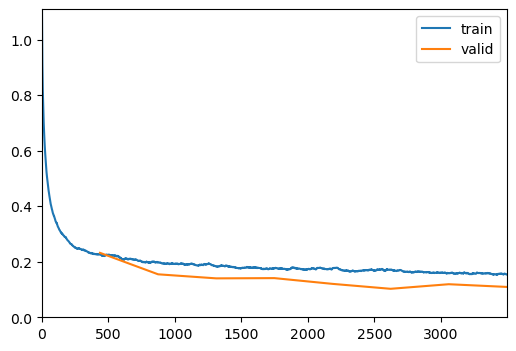

Better model found at epoch 1 with valid_loss value: 0.15473215281963348.
Better model found at epoch 2 with valid_loss value: 0.14013046026229858.
Better model found at epoch 4 with valid_loss value: 0.12031301856040955.
Better model found at epoch 5 with valid_loss value: 0.10254587978124619.


In [35]:
learn.fit_flat_cos(8, slice(lr), cbs=get_cbs(fname=save_fn, hole_size=hole_size, p=0.5)) 

In [29]:
#learn.load(save_fn);

### 500 x 500

In [36]:
bs=40

In [37]:
dls = get_multiband_dataloaders(df, x_name='image_lidar', y_name='mask',
                      codes=codes,
                      splitter=ColSplitter('is_val'), bs=bs,
                      item_tfms=get_multiband_item_tfms(),
                      batch_tfms=Normalize())

In [38]:
learn.dls = dls

In [39]:
hole_size = (200,200)
#hole_size = None

In [40]:
lrs = slice(lr/400, lr/4)

epoch,train_loss,valid_loss,dice,iou,time
0,0.307617,0.311499,0.661464,0.706323,27:13
1,0.234971,0.191788,0.814748,0.816570,27:11
2,0.204268,0.159613,0.848666,0.846794,27:12
3,0.182761,0.146923,0.864319,0.861378,27:11
4,0.167932,0.143154,0.874963,0.870946,27:12
5,0.157252,0.106106,0.911676,0.904775,27:12
6,0.145803,0.118290,0.897660,0.891890,27:12
7,0.146746,0.094812,0.923380,0.916344,27:12
8,0.144241,0.129494,0.890947,0.885857,27:12
9,0.132615,0.103041,0.912378,0.906079,27:11


Better model found at epoch 0 with valid_loss value: 0.3114994168281555.


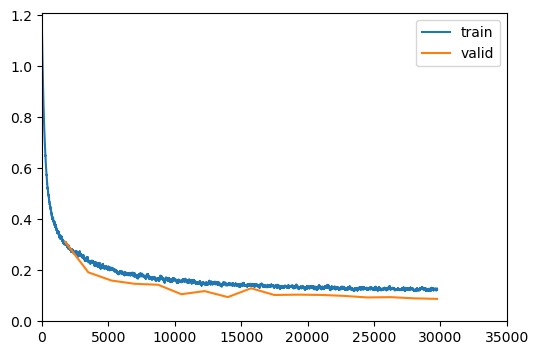

Better model found at epoch 1 with valid_loss value: 0.19178767502307892.
Better model found at epoch 2 with valid_loss value: 0.1596127599477768.
Better model found at epoch 3 with valid_loss value: 0.14692263305187225.
Better model found at epoch 4 with valid_loss value: 0.1431543380022049.
Better model found at epoch 5 with valid_loss value: 0.10610639303922653.
Better model found at epoch 7 with valid_loss value: 0.0948118045926094.
Better model found at epoch 13 with valid_loss value: 0.09342602640390396.
Better model found at epoch 15 with valid_loss value: 0.09003977477550507.
Better model found at epoch 16 with valid_loss value: 0.08775560557842255.


RuntimeError: unable to resize file <filename not specified> to the right size: Invalid argument (22)

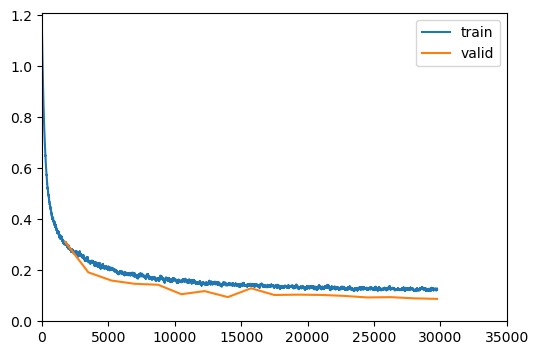

In [35]:
learn.fit_one_cycle(20, slice(lr), cbs=get_cbs(fname=save_fn, hole_size=hole_size)) 

In [45]:
learn.load(save_fn);

In [43]:
save_fn

'MapAI-stage_1-500_resnet34_aerial-lidar-2022-11-29'

In [ ]:
learn.show_results()

# Export

In [36]:
learn_export = unet_learner(dls, models[model_idx], n_in=4, n_out=2, 
                     loss_func=loss_func,
                     pretrained=False, 
                     metrics=metrics,self_attention=False).to_fp16() 

/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [37]:
learn_export.load(save_fn)

In [38]:
save_fn

'MapAI-stage_1-500_resnet34_aerial-lidar-2022-12-02-nocutmix-progressiveresize'

In [39]:
learn_export.export(save_fn + '.pkl')